In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

batch_size是批量大小，分批训练数据
num_step是时间步，每批数据的长度

In [2]:
F.one_hot(torch.tensor([0, 2]), len(vocab))#索引为 0 和 2 的独热向量

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [3]:
#转换输入的维度，以便获得形状为（时间步数, 批量大小, 词汇表大小）的输出。这将使我们能够更方便地通过最外层的维度，一步一步地更新小批量数据的隐藏状态
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape #转置

torch.Size([5, 2, 28])

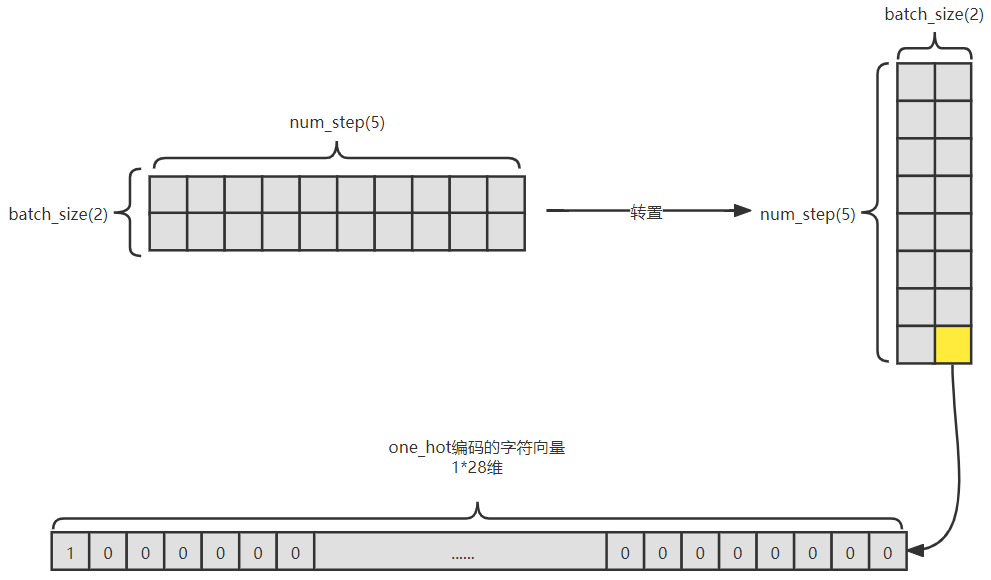

In [4]:
#初始化模型参数
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):#生成随机数
        return torch.randn(size=shape, device=device) * 0.01 #返回一个以0为平均值，标准差为1的正态分布随机数。size代表返回张量的形状

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))#输入到隐藏层
    W_hh = normal((num_hiddens, num_hiddens))#上一层隐藏层到本层的隐藏层
    b_h = torch.zeros(num_hiddens, device=device)#偏移量为0，输出的隐藏层的大小
    
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))#本层的隐藏层到输出层的大小
    b_q = torch.zeros(num_outputs, device=device)#偏移量为0，维度为输出层的大小
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True) #说明当前量是否需要在计算中保留对应的梯度信息
    return params
b_h = torch.zeros(3, device=d2l.try_gpu())#偏移量为0，输出的隐藏层的大小
b_h

tensor([0., 0., 0.], device='cuda:0')

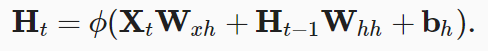

    X_t (batch_size * numinputs)   W_xh (numinputs * num_hiddens)

    H_t-1 (batch_size * num_hiddens)   W_hh (num_hiddens * num_hiddens)

    b_h (num_hiddens * 1)
    
    H_t (batch_size * num_hiddens)


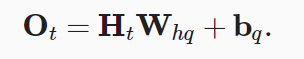
    
    H_t (batch_size * num_hiddens)     W_hq (num_hiddens * num_outputs)

    b_q (num_outputs * 1)
    
    O_t (batch_size * num_hiddens)


In [5]:
#0时刻，没有上一个的隐藏层状态，要初始化一个状态
#在初始化时返回隐藏状态 批量大小*隐藏单元数
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [6]:
#定义如何在一个时间步内计算隐藏状态和输出
def rnn(inputs, state, params):
    # `inputs`的形状：(`时间步数量`，`批量大小`，`词表大小`)
    W_xh, W_hh, b_h, W_hq, b_q = params #模型参数
    H, = state #隐藏状态
    outputs = []
    # `X`的形状：(`批量大小`，`词表大小`)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h) #隐藏层 torch.mm矩阵乘法
        Y = torch.mm(H, W_hq) + b_q #输出层
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,) #将T个样本按维度是dim=0排列起来(列不变)，之后返回更新的隐藏状态

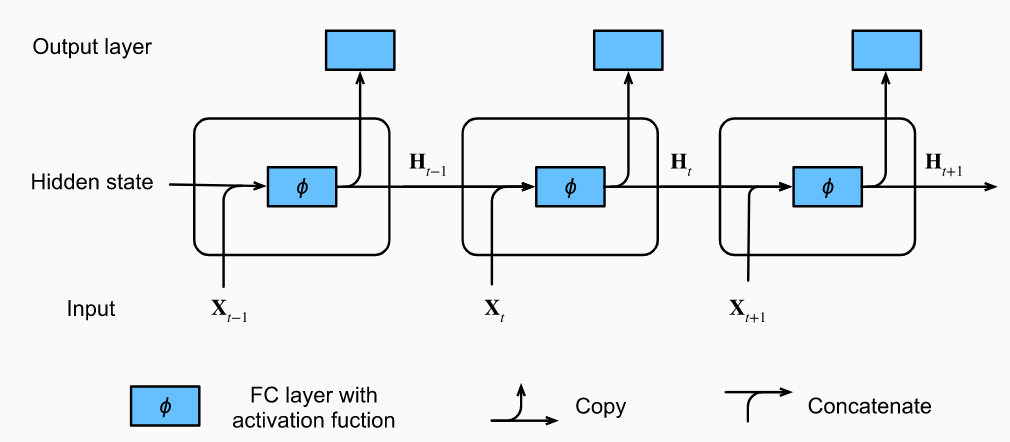
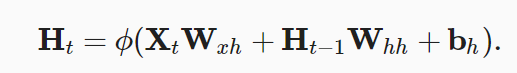
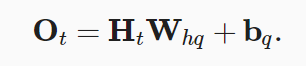

In [7]:
#网络模型
class RNNModelScratch: #@save
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn # forward_fn为通用前向传播 此处即定义的那个rnn函数

    def __call__(self, X, state):# 此处X为time Machine数据集load进来的X，大小batch_size*num_steps，注意与上面的X区分
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32) #X num_steps*batch_size*vocab_size 转成浮点型
        return self.forward_fn(X, state, self.params)#调用rnn函数，得到输出值和更新后的状态

    def begin_state(self, batch_size, device):# 调用上面的init_rnn_state 初始化0时刻隐藏状态
        return self.init_state(batch_size, self.num_hiddens, device)

In [8]:
#检查输出是否具有正确的形状，例如，是否保证了隐藏状态的维数保持不变
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())#X.shapep[0]即batch_size
Y, new_state = net(X.to(d2l.try_gpu()), state) #输出结果和下一状态
Y.shape, len(new_state), new_state[0].shape
#（时间步数5 × 批量大小2，词汇表大小28），而隐藏状态形状保持不变，即（批量大小, 隐藏单元数）

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [9]:
#定义预测函数来生成prefix之后的新字符，其中的prefix是一个用户提供的包含多个字符的字符串
def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """在`prefix`后面生成新字符。"""
    state = net.begin_state(batch_size=1, device=device)#初始化隐藏状态
    outputs = [vocab[prefix[0]]]#保存字符对应单词表下标
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))#上一时刻的输出作为当前的输入
    for y in prefix[1:]:  # 预热期，预热隐藏状态
        _, state = net(get_input(), state)#输入prefix，不需要保存预测的结果，主要是为了得到初始状态
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测`num_preds`步
        y, state = net(get_input(), state)#此处y为 1*vocab 的向量 [0,1,...,0]#取出y对应的字符下标
        outputs.append(int(y.argmax(dim=1).reshape(1)))#取出y对应的字符下标
    return ''.join([vocab.idx_to_token[i] for i in outputs])#将下标转为字符进行拼接

In [10]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())#未经过训练预测，效果很差

'time traveller ahbrl ahbr'

In [11]:
#梯度裁剪
def grad_clipping(net, theta):  #@save
    """裁剪梯度。"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params #自定义网络所有层的参数
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))#所有层的参数的梯度平方和再开方 norm理解为所有梯度的均值
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

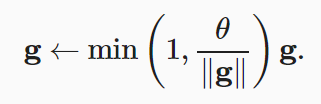

In [12]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练模型一个迭代周期（定义见第8章）。"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和, 词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化`state`
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state`对于`nn.GRU`是个张量
                state.detach_()
            else:
                # `state`对于`nn.LSTM`或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)#Y转置，时间拉到前面，n*1的向量，n=batch_size*num_steps
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)#y_hats是[batch_size*num_steps,vocab_size]
        l = loss(y_hat, y.long()).mean()#算出一个loss值
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()#反向传递
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()#反向传递
            grad_clipping(net, 1)#梯度裁剪
            # 因为已经调用了`mean`函数
            updater(batch_size=1)#更新模型参数
        metric.add(l * y.numel(), y.numel())#numel()返回元素个数      l*y.numel()所有loss相加
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()#metric[0] / metric[1]平均交叉熵 训练速度

In [13]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）。"""
    loss = nn.CrossEntropyLoss()#语言模型其实是一个多分类，所以使用交叉熵损失函数
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])#绘图
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)#随机梯度下降
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)#预测50个字符
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(#困惑度和训练速度
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:#每10个epoch输出一次
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1.0, 67044.5 词元/秒 cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


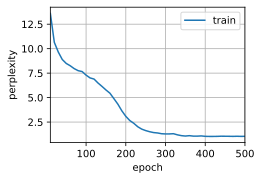

In [14]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

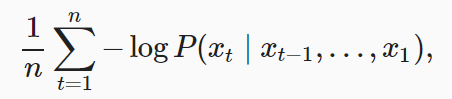
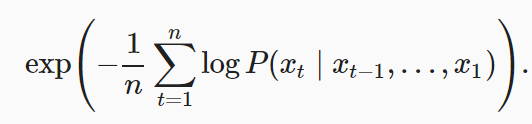

困惑度 1.3, 67547.7 词元/秒 cuda:0
time travellerit s against reason said filbywhat fion the soand 
traveller with a slight accession ofcheerfulness really thi


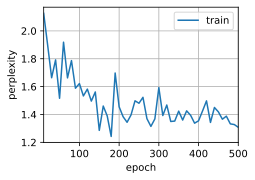

In [15]:
#基于随机采样的训练，采样时随机取一个sequence，与上一个批量无关，困惑度高
#每个iteration读取一个序列 iteration之间是随机的 随机性更强 可能出现一些奇怪的词
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),use_random_iter=True)